In [8]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


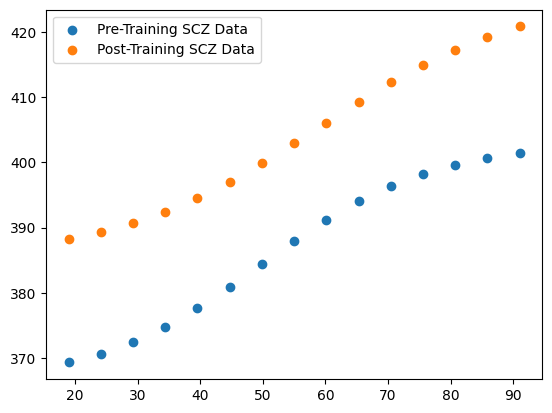

In [18]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)

##Post-Training
###SCZ
ymin = 385
ymax = 426
scz_cp_post = 100 - 1.361 * v
scz_slope_post = 1 / 0.061  # negative

SCZ_RTs_post = RTsig(a_distances, scz_cp_post, scz_slope_post)

plt.scatter(a_distances, SCZ_RTs, label="Pre-Training SCZ Data")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.legend()

In [19]:
from scipy.optimize import differential_evolution

Lex, Pr = 1.963e00, 1.044e-01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

k_a = 5e-05
k_v = 5e-05
stim_counts = 10

sigav_x, locav_x = 5.394e00, 3.271e01


def train_sczmodel(theta):
    rho_0 = theta[0]

    SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
        stim_counts,
        simtime,
        ts,
        SCZLt,
        SCZLa,
        SCZLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        Pr,
        rho_0,
        6.5,
        6.5,
        k_a,
        k_v,
        0.05,
        sigav_x,
        locav_x,
    )

    _, _, _, _, SCZrtpost = experiment(
        ts,
        simtime,
        a_distances,
        5,
        SCZLt,
        SCZLa,
        SCZLv,
        HCWt,
        SCZWa_tr[:, :, -1, -1],
        SCZWv_tr[:, :, -1, -1],
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = SCZrtpost
    yf = SCZ_RTs_post

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 0.1)]
train_sczmodel_res = differential_evolution(
    train_sczmodel, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 140.60145023692684
differential_evolution step 2: f(x)= 119.94810650673503
differential_evolution step 3: f(x)= 95.84639444229502
differential_evolution step 4: f(x)= 95.84639444229502
differential_evolution step 5: f(x)= 59.312408941220355
differential_evolution step 6: f(x)= 24.138507892451393
differential_evolution step 7: f(x)= 20.805937364855303
differential_evolution step 8: f(x)= 14.40671729199359
differential_evolution step 9: f(x)= 14.40671729199359
differential_evolution step 10: f(x)= 14.40671729199359
differential_evolution step 11: f(x)= 14.40671729199359
differential_evolution step 12: f(x)= 14.40671729199359
differential_evolution step 13: f(x)= 13.67986711355039
differential_evolution step 14: f(x)= 13.67986711355039
differential_evolution step 15: f(x)= 13.67986711355039
differential_evolution step 16: f(x)= 13.67986711355039
differential_evolution step 17: f(x)= 13.67986711355039
differential_evolution step 18: f(x)= 13.67986711355

In [21]:
print(train_sczmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 13.67986711355039
                   x: [ 6.159e-05]
                 nit: 19
                nfev: 300
          population: [[ 6.159e-05]
                       [ 6.166e-05]
                       ...
                       [ 6.427e-05]
                       [ 6.171e-05]]
 population_energies: [ 1.368e+01  1.368e+01 ...  1.400e+01  1.368e+01]


In [22]:
## Fitted model

Lex, Pr = 1.963e00, 1.044e-01
rho_0 = 6.159e-05
sigav_x, locav_x = 5.394e00, 3.271e01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    sigav_x,
    locav_x,
)


_, _, _, _, SCZ_Model_RTs_post = experiment(
    ts,
    simtime,
    a_distances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    SCZWa_tr[:, :, -1, -1],
    SCZWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

SCZ_Model_RTs_post = fit_RT(SCZ_Model_RTs_post, SCZ_RTs_post)

In [23]:
_, _, _, _, SCZ_Model_RTs_pre = experiment(
    ts,
    simtime,
    a_distances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    0,
)

SCZ_RTs_model_pre = fit_RT(SCZ_Model_RTs_pre, SCZ_RTs_post)

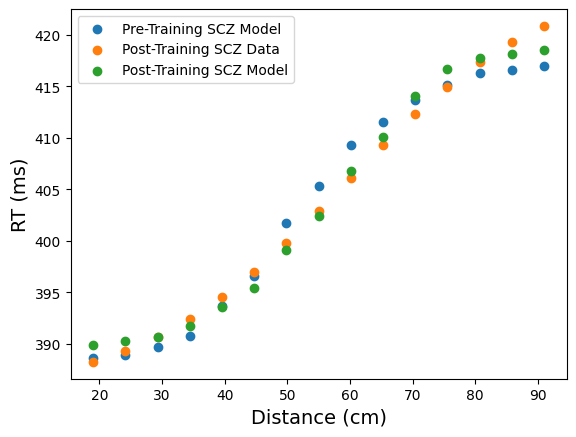

In [26]:
plt.scatter(a_distances, SCZ_RTs_model_pre, label="Pre-Training SCZ Model")
plt.scatter(a_distances, SCZ_RTs_post, label="Post-Training SCZ Data")
plt.scatter(a_distances, SCZ_Model_RTs_post, label="Post-Training SCZ Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()